## Config

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import sys
p = os.path.join(os.path.dirname('__file__'), '..')
sys.path.append(p)
from common import *
from imutils.object_detection import non_max_suppression

from matplotlib import animation, rc
from IPython.display import HTML
from matplotlib.pyplot import Rectangle

In [ ]:
DATA_DIR = '../data/'
json_fpath = os.path.join(DATA_DIR, 'volleyball_frame_00665.json')
img_fpath = os.path.join(DATA_DIR, 'volleyball_frame_00665.png')
IMG_DIR = os.path.join(DATA_DIR, 'volleyball', 'images_subset')
metadata_fpath = os.path.join(DATA_DIR, 'volleyball_bbox_labels.csv')
FIGSIZE = (18,18)

## Helpers

In [ ]:
def plot_img(arr, fs=FIGSIZE, cmap='gray', title=None):
    plt.figure(figsize=fs)
    plt.imshow(arr, cmap=cmap)
    plt.title(title)
    plt.show()
    
def load_img(fpath):
    return plt.imread(fpath)

def load_cv2_img(fpath, w=None, h=None, colorspace=None):
    img = cv2.imread(fpath)
    if colorspace is not None:
        img = cv2.cvtColor(img, colorspace)
    if None not in [w,h]:
        img = cv2.resize(img, (w, h), interpolation=cv2.INTER_CUBIC)
    return img

def threshold_color(img, color, thresh, sigma=1.0):
    """
    color = [b, g, r] or [r,b,g] or [h,s,v]
    thresh = [b,g,r] margin allowed around color (1 per channel)
    """
    if isinstance(thresh, int):
        thresh = [thresh]*3
    thresh = np.array(thresh) * sigma
    min_color = np.array([color[0]-thresh[0], color[1]-thresh[1], 
                          color[2]-thresh[2]])
    max_color = np.array([color[0]+thresh[0], color[1]+thresh[1],
                          color[2]+thresh[2]])
    min_color[min_color < 0] = 0
    max_color[max_color > 255] = 255
    print("Min", min_color)
    print("Max", max_color)
    
    mask = cv2.inRange(img, min_color, max_color)
    result = cv2.bitwise_and(img, img, mask=mask)
    return mask, result

def get_color_of_pixel(fpath, x, y, colorspace='BGR'):
    rgb_img = load_cv2_img(img_fpath, colorspace=cv2.COLOR_BGR2RGB)
    hsv_img = load_cv2_img(img_fpath, colorspace=cv2.COLOR_BGR2HSV)
    
    rgb_colors = rgb_img[y,x,:]
    hsv_colors = hsv_img[y,x,:]
    bgr_colors = np.copy(rgb_colors[::-1])
    print ("BGR:", bgr_colors)
    print ("RGB:", rgb_colors)
    print ("HSV:", hsv_colors)
    
    # Plot to visualize
    img = np.copy(rgb_img)
    img[y-5:y+5:,x-5:x+5,:] = 255
    img[y,x,:] = 0
    
    if colorspace == 'BGR':
        return bgr_colors.tolist()
    if colorspace == 'RGB':
        return rgb_colors.tolist()
    return hsv_colors.tolist()

def get_hsv_value_of_bgr(bgr_color):
    print("BGR", bgr_color)
    bgr_color = np.uint8([[bgr_color]])
    hsv = cv2.cvtColor(bgr_color, cv2.COLOR_BGR2HSV)[0][0]
    print("HSV", hsv)
    return hsv

# Create color histograms representing average values among samples
def get_flattened_channels(imgs):
    chans = np.empty(shape=(1,3))
    for img in imgs:
        h,w,c = img.shape
        reshaped = img.reshape((h*w, c))
        chans = np.concatenate([chans, reshaped], axis=0)
        #print(reshaped.shape, chans.shape)
    return chans

def get_color_hist(img, bins, mask=None):
    hist = cv2.calcHist(
        [img], [0,1,2], mask, [bins,bins,bins], 
        [0, 256, 0, 256, 0, 256])
    return cv2.normalize(hist, hist).flatten()

def plot_hists(hists, title="None"):
    colors = ('r','g','b')
    for col,hist in zip(colors, hists):
        plt.plot(hist, color=col)
    plt.title(title)    
    plt.show()

def get_color_hist_dict(img, bins, mask):
    hists = {}
    color = ('r','g','b')
    for i,col in enumerate(color):
        histr = cv2.calcHist([img],[i],mask,[bins],[0,256])
        hists[col] = histr
    return hists

# Plotting Histogram (all channels flattened)
def plot_hist(img, bins=256, title=None):
    plt.hist(img.ravel(), bins=bins, range=[0,256])
    plt.title(title)
    plt.show()

def plot_bgr_hist(bgr_img, bins=256, mask=None):
    # Mask let's you select for certain regions
    color = ('b','g','r')
    for i,col in enumerate(color):
        histr = cv2.calcHist([bgr_img],[i],mask,[bins],[0,256])
        plt.plot(histr, color=col)
        plt.xlim([0,bins])
    plt.show()

def plot_hists_dict(hists):
    for col,hist in hists.items():
        plt.plot(hist, color=col)
    plt.show()
    
def plot_bbs_from_rectLabel_annos(json_fpath, img_fpath):
    bb_json = json.load(open(json_fpath, 'r'))
    fig = plt.figure(figsize=FIGSIZE)
    axes = plt.axes([0, 0.03, 1, 0.97])
    
    img = plt.imread(img_fpath)
    imgplot = axes.imshow(img)

    for box in bb_json['objects']:
        label = box['label']
        color = BOX_COLORS[label]
        coords = box['x_y_w_h']
        bb = Rectangle(
            (coords[0],coords[1]), 
            coords[2], coords[3],
            fill=False,
            edgecolor=color,
            linewidth=2)
        axes.add_patch(bb)
        
def get_img_crops_from_rectLabel_bbs(img, json_fpath):
    crops_dict = {}
    bb_json = json.load(open(json_fpath, 'r'))
    for box in bb_json['objects']:
        label = box['label']
        x,y,w,h = box['x_y_w_h']
        crop = img[y:y+h,x:x+w,:]
        if label not in crops_dict:
            crops_dict[label] = []
        crops_dict[label].append(crop)
    return crops_dict

def make_boxes(meta):
    boxes = {}
    for idx,row in meta.iterrows():
        box = json.loads(row.to_json())
        fname = row['filename']
        if fname in boxes:
            boxes[fname].append(box)
        else:
            boxes[fname] = [box]
    return boxes

def median_filter(mask, ksize=3, thresh=25):
    median = cv2.medianBlur(mask, ksize)
    return median

def opening(img, ksize=(3,3)):
    # Erode --> Dilate
    erode_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, ksize)
    dilate_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, ksize)
    img = cv2.erode(img, erode_kernel, iterations = 1)
    img = cv2.dilate(img, dilate_kernel, iterations = 1)
    return img

def closing(img, ksize=(3,3)):
    # Dilate --> Erode
    erode_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, ksize)
    dilate_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, ksize)
    img = cv2.dilate(img, dilate_kernel, iterations = 1)
    img = cv2.erode(img, erode_kernel, iterations = 1)
    return img

def apply_bg_mask(fpaths, subtractor, limit=100, cleanup=None):
    i = 0
    masks = []
    for fpath in fpaths:
        img = load_cv2_img(fpath, colorspace=cv2.COLOR_BGR2RGB)
        fgmask = subtractor.apply(img)
        if cleanup == 'open':
            fgmask = opening(fgmask)
        elif cleanup == 'close':
            fgmask = closing(fgmask)
        elif cleanup == 'median':
            fgmask = median_filter(fgmask)
        fgmask[fgmask >= 2] = 255
        fgmask[fgmask < 2] = 0
        masks.append(fgmask)
        if i > limit:
            break
        i+=1
    return masks

def get_masked_imgs(fpaths, masks):
    imgs = []
    for fpath, mask in zip(fpaths, masks):
        img = load_cv2_img(fpath, colorspace=cv2.COLOR_BGR2RGB)
        img[mask == 0] = 255
        imgs.append(img)
    return imgs

def get_img_crop(img, x1, y1, x2, y2):
    if len(img.shape) > 2:
        return img[y1:y2,x1:x2,:]
    return img[y1:y2,x1:x2]

def plot_boxes(img, rects, title="boxes", color=(255,255,255), thick=2, texts=None, gt_box=None):
    font = cv2.FONT_HERSHEY_COMPLEX_SMALL
    cv2.rectangle(img, (gt_box[0], gt_box[1]), (gt_box[2], gt_box[3]), (255,0,0), 1 )
    for (x1, y1, x2, y2), text in zip(rects, texts):
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 1 )
        cv2.putText(img, text, (x1,y1), font, 1, (255,255, 255), 1, cv2.LINE_AA)
    plot_img(img, title=title)
    
    
def get_genius_box(fname, gt_boxes):
    """
    {'filename': 'volleyball_frame_00665.png',
       'fpath': '../data/volleyball/images_subset/volleyball_frame_00665.png',
       'label_id': 1,
       'label_name': 'ball',
       'x1': 45.5,
       'x2': 64.5,
       'y1': 175.0,
       'y2': 195.0}
       """
    bb = gt_boxes[fname][0]
    coords = [bb['x1'],bb['y1'],bb['x2'],bb['y2']]
    coords = [int(c) for c in coords]
    return coords

In [ ]:
metadata = pd.read_csv(metadata_fpath)
metadata['label_name'] = 'ball'
metadata['label_id'] = 1
fnames = metadata['filename']
fpaths = [os.path.join(IMG_DIR, f) for f in fnames]
metadata['fpath'] = fpaths
GT_BOXES = make_boxes(metadata)

In [ ]:
# There are 120 images with no box
areas = []
aspect_ratios = []
for fname,fpath in zip(metadata['filename'], metadata['fpath']):
    box = get_genius_box(fname, GT_BOXES)
    w = box[2]-box[0]
    h = box[3]-box[1]
    areas.append(w*h)
    if w*h == 0.0:
        aspect_ratios.append(0.0)
    else:
        aspect_ratios.append(float(w)/h)
#     if w*h == 0:
#         print(box, fname)
#         img = load_cv2_img(fpath, colorspace=cv2.COLOR_BGR2RGB)
#         plot_img(img, fs=(10,10))

## Background Subtraction

In [ ]:
len(areas),len(metadata)
areas = [area for area in areas if area > 0]
aspects = [a for a in aspect_ratios if a > 0]
mean = np.mean(np.array(areas))
median = np.median(np.array(areas))
mins = np.min(np.array(areas))
maxs = np.max(np.array(areas))
plt.hist(areas, bins=50)
mean,median,mins,maxs

In [ ]:
aspects = [a for a in aspect_ratios if a > 0]
mean = np.mean(np.array(aspects))
median = np.median(np.array(aspects))
mins = np.min(np.array(aspects))
maxs = np.max(np.array(aspects))
plt.hist(aspects, bins=50)
mean,median,mins,maxs

* https://pdfs.semanticscholar.org/8a1f/27fd371eceb8654b735502b810d2094e420b.pdf
* http://airccj.org/CSCP/vol7/csit76313.pdf
* http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.131.3661&rep=rep1&type=pdf
* https://www.sciencedirect.com/science/article/pii/S2213020916300866
* https://github.com/ITCoders/Human-detection-and-Tracking/blob/master/main.py
* https://github.com/OpenPTrack/open_ptrack

### Background Model

In [ ]:
## KNN Subtraction seems to work better
def segment_knn(fpaths, subtractor, kernel, plot_mask=True):
    i = 0
    for fpath in fpaths:
        img = load_cv2_img(fpath, colorspace=cv2.COLOR_BGR2RGB)
        fgmask = subtractor.apply(img)
        #fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_OPEN, kernel)
        if plot_mask and i > 0 and i % 500 == 0:
            plot_img(fgmask, fs=FIGSIZE, title=fpath)    
        i+=1
    return subtractor.getBackgroundImage()

In [ ]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
knn_subtractor = cv2.createBackgroundSubtractorKNN()
bg_img = segment_knn(metadata['fpath'], knn_subtractor, kernel, plot_mask=True)

In [ ]:
# Median Filter
# Clears out the Salt and pepper noise
# https://docs.opencv.org/3.1.0/d4/d13/tutorial_py_filtering.html
plot_img(bg_img, fs=FIGSIZE)
median = cv2.medianBlur(bg_img, 5)
plot_img(median, fs=FIGSIZE)

### Extract Masks

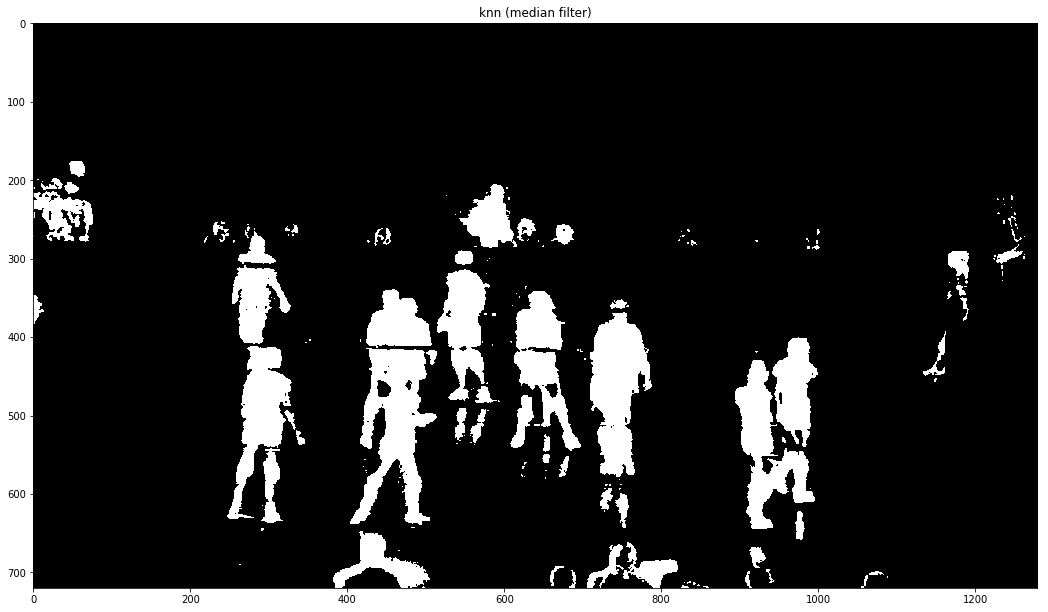

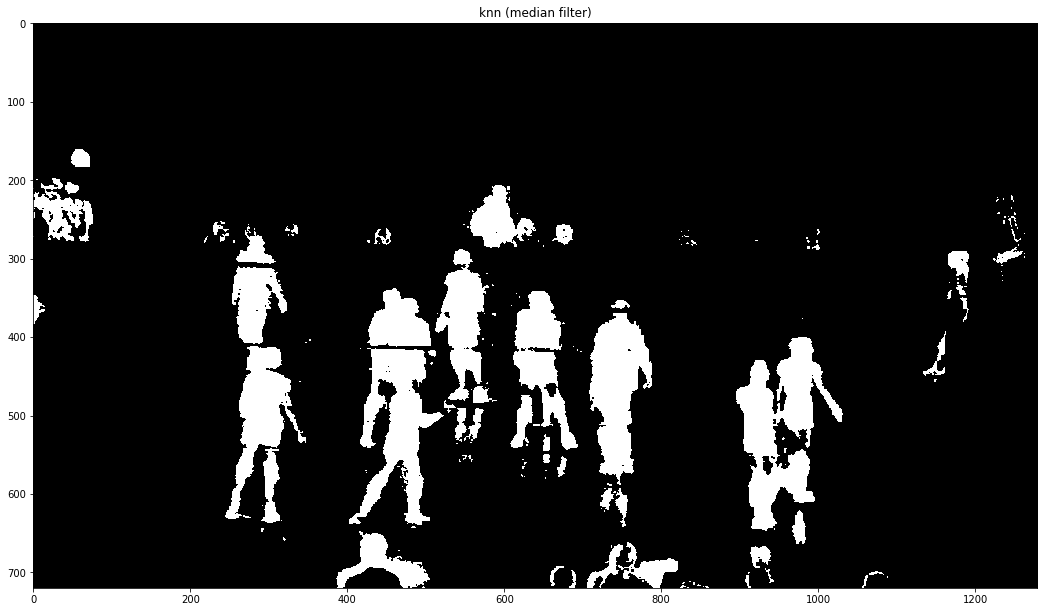

In [87]:
# Binary Mask
plot_limit = 2
binary_masks = apply_bg_mask(metadata['fpath'], knn_subtractor, limit=1400, cleanup='median')
for m in binary_masks[:plot_limit]:
    plot_img(m, title='knn (median filter)')

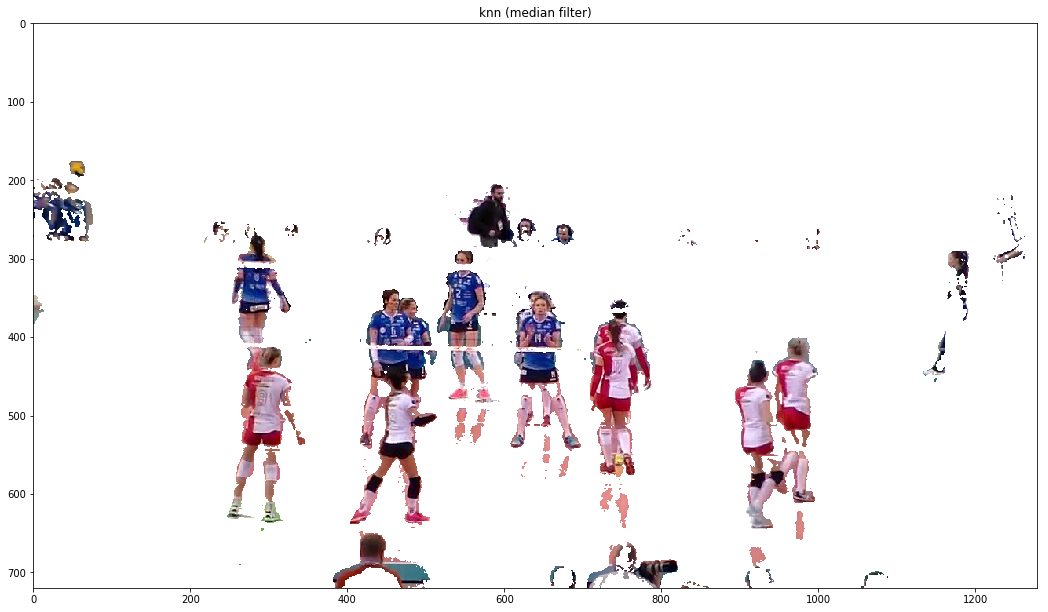

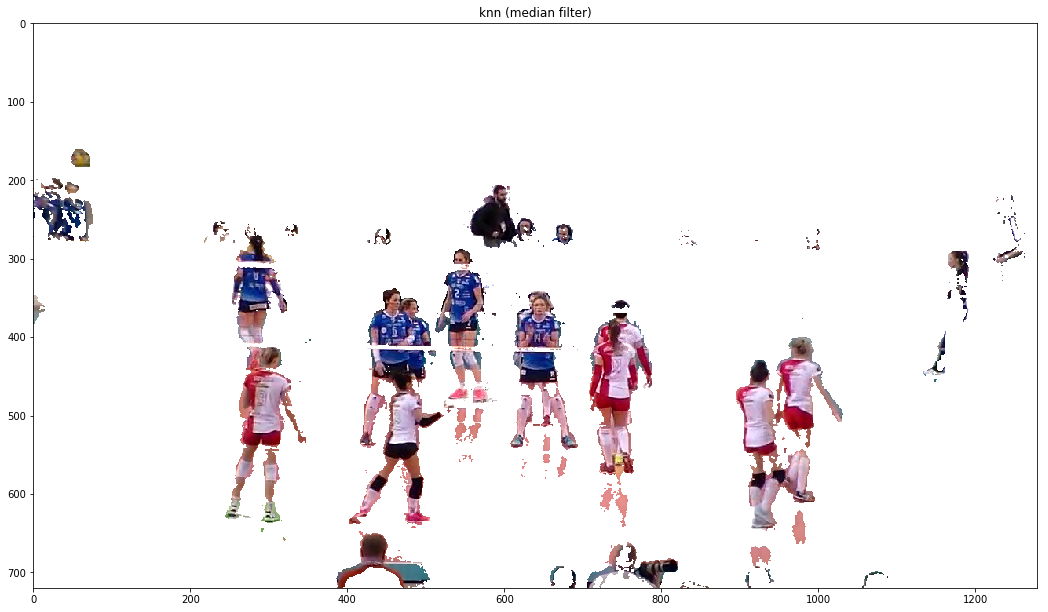

In [88]:
# Color Masks
color_masks = get_masked_imgs(metadata['fpath'], binary_masks)
for m in color_masks[:plot_limit]:
    plot_img(m, title='knn (median filter)')

### Mask Cleanup

In [89]:
def cleanup_mask(mask, cleanup_type):
    if cleanup_type == 'median':
        return cv2.medianBlur(mask, ksize=9)
    elif cleanup_type == 'gaussian':
        return cv2.GaussianBlur(mask, ksize=(9,9), sigmaX=2)
    elif cleanup_type == 'open':
        return opening(mask, ksize=(7,7))
    elif cleanup_type == 'close':
        return opening(mask, ksize=(5,5))
    else:
        raise Exception("Cleanup type not found")
        
def clean_masks(masks, cleanup_type):
    for i,mask in enumerate(masks):
        masks[i] = cleanup_mask(mask, cleanup_type)
    return masks

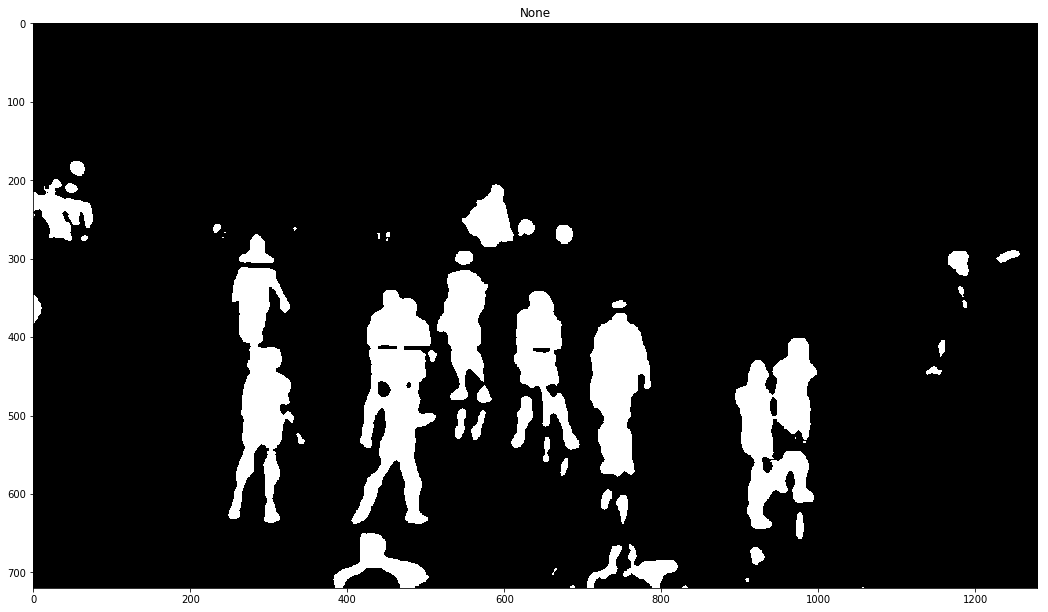

In [90]:
clean_mask = cleanup_mask(binary_masks[0], 'median')
plot_img(clean_mask)

## Find Contours


* https://docs.opencv.org/3.2.0/d0/d49/tutorial_moments.html
* http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_contours/py_contour_properties/py_contour_properties.html

In [91]:
def get_contours(binary_mask):
    image, contours, hierarchy = cv2.findContours(binary_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return contours

def plot_contours(img, contours, color=(255,255,255), thick=2):
    img = img.copy()
    img = cv2.drawContours(img, contours, -1, color, thickness=thick)
    plot_img(img)

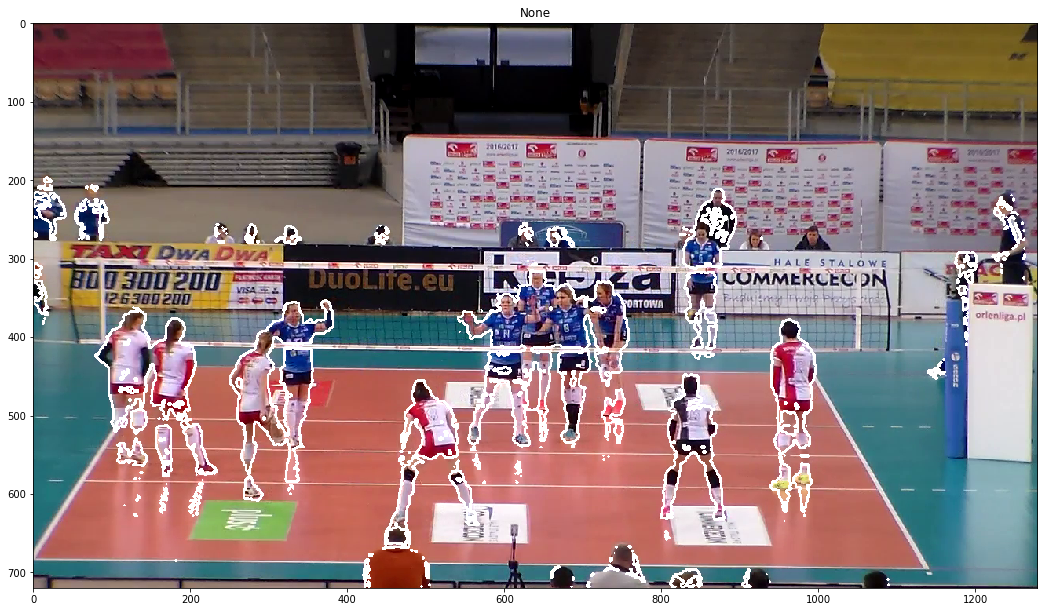

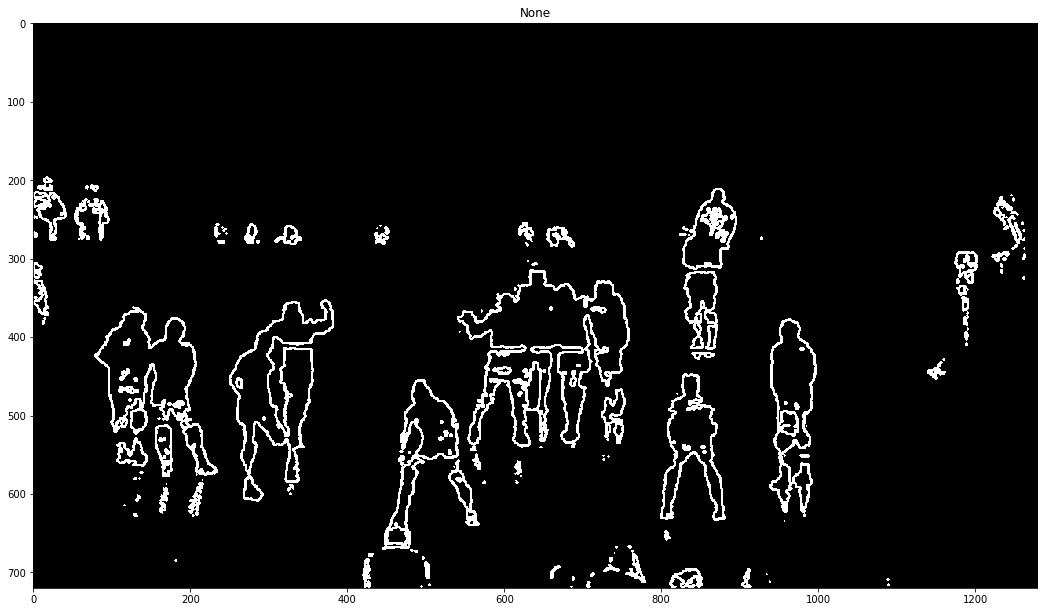

In [92]:
idx = 700
img = load_cv2_img(metadata['fpath'][idx], colorspace=cv2.COLOR_BGR2RGB)
bm = binary_masks[idx].copy()
cm = color_masks[idx].copy()
contours = get_contours(bm)
plot_contours(img, contours)
plot_contours(bm, contours)

## Color Matching

In [93]:
def box_area(b):
    # x1,y1,x2,y2
    w = b[2]-b[0]
    h = b[3]-b[1]
    return w * h
    
def box_iou(b1, b2):
    # x1,y1,x2,y2
    x1 = max(b1[0], b2[0]) 
    y1 = max(b1[1], b2[1]) 
    x2 = min(b1[2], b2[2]) 
    y2 = min(b1[3], b2[3])
    if x2 <= x1 or y2 <= y1:
        return 0.0
    intersection = (x2-x1)*(y2-y1)
    union = box_area(b1) + box_area(b2) - intersection
    return intersection / union

def get_crops(metadata, bbs, pad, crop_limit):
    all_crops = []
    for idx in range(len(metadata[:crop_limit])):
        fname = metadata['filename'][idx]
        fpath = metadata['fpath'][idx]
        img = load_cv2_img(fpath, colorspace=cv2.COLOR_BGR2RGB)
        bb = bbs[fname]
        crops = get_crops_from_bbs(img, bb, pad)
        all_crops.append(crops)
    return all_crops

def get_random_crops(fpaths, width, height, n_crops):
    crops = []
    for fpath in fpaths[:n_crops]:
        img = load_cv2_img(fpath, colorspace=cv2.COLOR_BGR2RGB)
        h,w,c = img.shape
        x1 = random.randint(0, w-width)
        x2 = x1 + width
        y1 = random.randint(0, h-width)
        y2 = y1 + height
        crop = get_img_crop(img, x1, y1, x2, y2)
        crops.append(crop)
    return crops

def get_valid_crops(crops):
    valid_crops = []
    for crop in crops:
        h,w,c = crop[0].shape
        if h > 1 and w > 1:
            valid_crops.append(crop[0])
    return valid_crops

def get_box_crops(fpaths, boxes, colorspace=cv2.COLOR_BGR2HSV):
    crops = []
    for fpath,box in zip(fpaths, boxes):
        img = load_cv2_img(fpath, colorspace=colorspace)
        if box_area(box) > 0:
            x1,y1,x2,y2 = box
            crop = get_img_crop(img, x1, y1, x2, y2)
            crops.append(crop)
    return crops

def get_norm_hue_hist(img, bins, mask=None):
    img_hist = cv2.calcHist(
        img, [0], mask, [bins], 
        [0, 256])
    img_hist = img_hist.flatten()
    img_hist = img_hist / np.linalg.norm(img_hist)
    return img_hist

def get_hist_of_box(img, box, bins):
    x1,y1,x2,y2 = box
    crop = get_img_crop(img, x1, y1, x2, y2)
    color = cv2.mean(crop)
    hist = get_color_hist(crop, bins=bins)
    hist_dict = get_color_hist_dict(crop, bins=bins, mask=None)
    return hist, hist_dict, color

def get_avg_hist_of_imgs(imgs, bins):
    chans = get_flattened_channels(imgs)
    hists = []
    for i in range(len(chans[0])):
        hist, bins = np.histogram(chans[:,i], bins, [0,256])
        hists.append(hist)
    return hists

from scipy.spatial import distance as dist
SCIPY_METHODS = (
    ("Euclidean", dist.euclidean),
    ("Manhattan", dist.cityblock),
    ("Chebysev", dist.chebyshev))

def get_hist_similarity(img, base_hist):
    results = {name:[] for name,_ in SCIPY_METHODS}
    img_hist = cv2.calcHist(
        img, [0], None, [len(base_hist)], 
        [0, 256])
    img_hist = img_hist.flatten()
    img_hist = img_hist / np.linalg.norm(img_hist)
    for methodName, method in SCIPY_METHODS:
        d = method(img_hist, base_hist)
        results[methodName].append(d)
    return results

def compare_img_hist_to_baseline(imgs, base_hist, bins):
    results = {name:[] for name,_ in SCIPY_METHODS}
    for img in imgs:
        img_hist = cv2.calcHist(
            img, [0], None, [bins], 
            [0, 256])
        img_hist = img_hist.flatten()
        img_hist = img_hist / np.linalg.norm(img_hist)
        for methodName, method in SCIPY_METHODS:
            d = method(img_hist, base_hist)
            results[methodName].append(d)
    return results

In [94]:
bins = 10
gt_boxes = [get_genius_box(f, GT_BOXES) for f in metadata['filename']]
ball_crops = get_box_crops(metadata['fpath'], gt_boxes[:])

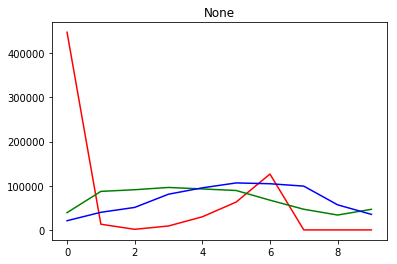

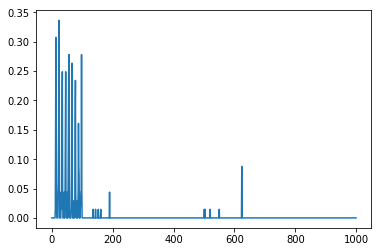

In [95]:
avg_ball_hist = get_avg_hist_of_imgs(ball_crops, bins=bins)
plot_hists(avg_ball_hist)
comb_hist = cv2.calcHist(
    ball_crops, [0, 1, 2], None, [bins, bins, bins], 
    [0, 256, 0, 256, 0, 256])
avg_ball_norm_hist = cv2.normalize(comb_hist, comb_hist).flatten()
plt.plot(avg_ball_norm_hist)

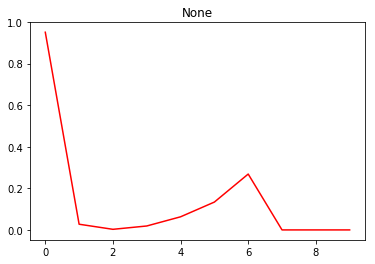

In [96]:
# Avg Hue is yellowish!
# http://hslpicker.com/#ffb300
avg_ball_hue_hist = avg_ball_hist[0]
avg_ball_hue_hist = avg_ball_hue_hist / np.linalg.norm(avg_ball_hue_hist)
plot_hists([avg_ball_hue_hist])

In [97]:
rand_crops = get_random_crops(metadata['fpath'], 20, 20, n_crops=1000)

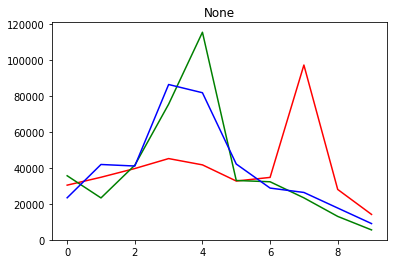

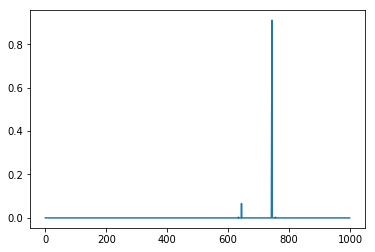

In [98]:
bins = 10
avg_rand_hist = get_avg_hist_of_imgs(rand_crops, bins=bins)
plot_hists(avg_rand_hist)
comb_hist = cv2.calcHist(
    rand_crops, [0, 1, 2], None, [bins, bins, bins], 
    [0, 256, 0, 256, 0, 256])
avg_rand_norm_hist = cv2.normalize(comb_hist, comb_hist).flatten()
plt.plot(avg_rand_norm_hist)

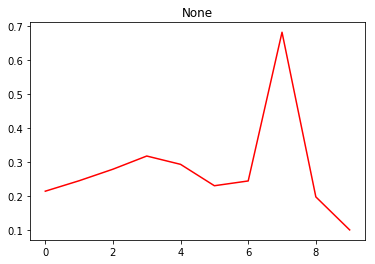

In [99]:
# Avg Hue
avg_rand_hue_hist = avg_rand_hist[0]
avg_rand_hue_hist = avg_rand_hue_hist / np.linalg.norm(avg_rand_hue_hist)
plot_hists([avg_rand_hue_hist])

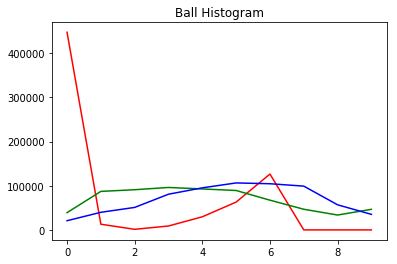

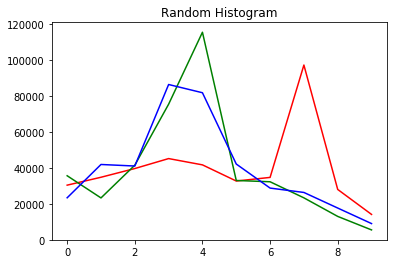

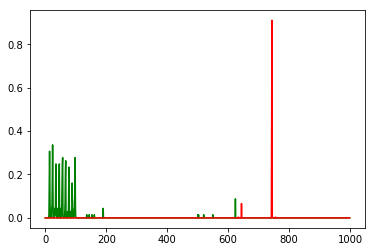

In [100]:
plot_hists(avg_ball_hist, title="Ball Histogram")
plot_hists(avg_rand_hist, title="Random Histogram")
plt.plot(avg_ball_norm_hist, color='g')#, title="Ball Histogram (Norm)")
plt.plot(avg_rand_norm_hist, color='r')#, title="Random Histogram (Norm)")

In [101]:
get_hist_similarity(ball_crops[0], avg_ball_hue_hist)

{'Chebysev': [0.55444599071583966],
 'Euclidean': [0.89367135624841],
 'Manhattan': [1.9980227734847582]}

In [102]:
ball_ball_results = compare_img_hist_to_baseline(ball_crops, avg_ball_hue_hist, bins=bins)
ball_rand_results = compare_img_hist_to_baseline(ball_crops, avg_rand_hue_hist, bins=bins)

In [103]:
rand_rand_results = compare_img_hist_to_baseline(rand_crops, avg_rand_hue_hist, bins=bins)
rand_ball_results = compare_img_hist_to_baseline(rand_crops, avg_ball_hue_hist, bins=bins)

BALL BALL
Euclidean: Mean: 0.865 Median:0.849
Manhattan: Mean: 1.956 Median:1.908
Chebysev: Mean: 0.585 Median:0.555
RAND BALL
Euclidean: Mean: 1.243 Median:1.344
Manhattan: Mean: 2.51 Median:2.681
Chebysev: Mean: 0.877 Median:0.951


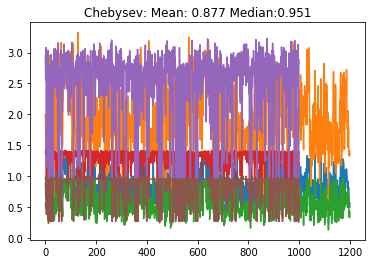

In [104]:
print("BALL BALL")
for key, vals in ball_ball_results.items():
    title = key +  ": Mean: " + str(round(np.mean(vals),3)) +  " Median:" + str(round(np.median(vals),3))
    print(title)
    plt.plot(vals)
    plt.title(title)

print("RAND BALL")
for key, vals in rand_ball_results.items():
    title = key +  ": Mean: " + str(round(np.mean(vals),3)) +  " Median:" + str(round(np.median(vals),3))
    print(title)
    plt.plot(vals)
    plt.title(title)

## Extract Ball Candidates

In [105]:
def filter_contours(contours, binary_mask, color_mask, img):
    cntrs = []
    bbs = []
    color_means = []
    color_hists = []
    diameters = []
    areas = []
    circularities = []
    aspects = []
    for cnt in contours:
        valid = True
        x,y,w,h = cv2.boundingRect(cnt)
        aspect_ratio = float(w)/h

        # Let's store color information
        mask = np.zeros(binary_mask.shape, np.uint8)
        cv2.drawContours(mask, [cnt], 0, 255, -1)
        color = cv2.mean(img, mask = mask)
        
        # Let's get Hue Histogram
        x,y,w,h = cv2.boundingRect(cnt)
        x1,y1,x2,y2 = x,y,x+w,y+h
        crop = get_img_crop(img, x1,y1,x2,y2)
        hist = get_norm_hue_hist(img, bins)

        # We assume ball box needs to be square-ish
        if aspect_ratio > 3.0 or aspect_ratio < .3:
            valid = False
            
        # Area, perimeter, diameter, circularity
        area = cv2.contourArea(cnt)
        equi_diameter = np.sqrt(4*area/np.pi)
        perimeter = cv2.arcLength(cnt, True)
        
        if perimeter > 0.1:
            circularity = (4*np.pi*area) / (perimeter*perimeter)
        else:
            circularity = 0.0
            
        # We assume the ball box needs to be < 2000 pixels 
        # Ball areas are between 200 and 1500 based on gt boxes
        #area = w*h
        if area < 150 or area > 1700:
            valid = False
        
        if valid:
            bbs.append((x,y,x+w,y+h))
            cntrs.append(cnt)
            color_means.append(color)
            color_hists.append(hist)
            diameters.append(equi_diameter)
            areas.append(area)
            circularities.append(circularity)
            aspects.append(aspect_ratio)
            
    return cntrs, bbs, color_hists, color_means, diameters, areas, circularities, aspects

In [106]:
img = load_cv2_img(metadata['fpath'][idx], colorspace=cv2.COLOR_BGR2RGB)
bm = binary_masks[idx].copy()
cm = color_masks[idx].copy()
cntrs, bbs, color_hists, color_means, diameters, areas, circularities, aspects = filter_contours(
    contours, bm, cm, img)

In [116]:
idxs = [random.randint(0,len(binary_masks)-1) for i in range(1300)]
idxs = [i for i in range(len(metadata))]
print(len(idxs))
matches = []
no_matches = []
no_boxes = []
candidates = []
found = 0
no_box = 0
for idx in idxs:
    match_found = False
    fname = metadata['filename'][idx]
    gt_box = get_genius_box(fname, GT_BOXES)
    img = load_cv2_img(metadata['fpath'][idx], colorspace=cv2.COLOR_BGR2HSV)
    bm = binary_masks[idx].copy()
    cm = color_masks[idx].copy()
    contours = get_contours(bm)
    cntrs, bbs, color_hists, color_means, diameters, areas, circularities, aspects = filter_contours(
        contours, bm, cm, img)
    texts = []
    sub_candidate = []
    for ctr, bb, hist, col, dia, area, cir, asp in zip(cntrs, bbs, color_hists, color_means, 
                                                       diameters, areas, circularities, aspects):
        dia = round(dia, 2)
        area = round(area, 2)
        cir = round(cir, 2)
        asp = round(asp, 2)
        bb_iou = box_iou(bb, gt_box)
        crop = get_img_crop(img, bb[0], bb[1], bb[2], bb[3])
        hist_sim = get_hist_similarity(crop, avg_ball_hue_hist)
        text = '{:.2f}'.format(bb_iou)
        
        if bb_iou > .0:
            match_found = True
            sub_status = 'match'
        else:
            sub_status = 'no_match'
        sub_candidate.append({
            'bb':bb,
            'diameter':dia,
            'area':area,
            'circle': cir,
            'aspect':asp,
            'iou':bb_iou,
            'color':col,
            'hist':hist,
            'hist_sim':hist_sim,
            'status':sub_status,
            'text':text
        })
        
    if box_area(gt_box) == 0:
        status = 'no_box'
        no_box += 1
    elif match_found:
        status = 'match'
        found +=1 
    else:
        status = 'no_match'
        
    
    candidates.append([fname, status, gt_box, sub_candidate])
    #plot_boxes(img, bbs, color=(0,255,0), thick=3, texts=texts, gt_box=gt_box)

1320


In [125]:
total = len(idxs)
no_box = len([b for b in gt_boxes if np.sum(b) == 0])
missed = len(idxs)-found-no_box
print("Matches:", found, "NoBox:", no_box, "Missed:", missed, "HitRate:", found/(total-no_box))

Matches: 734 NoBox: 120 Missed: 466 HitRate: 0.6116666666666667


In [156]:
circles = {'match':[], 'no_match':[]}
areas = {'match':[], 'no_match':[]}
colors = {'match':[], 'no_match':[]}
aspects = {'match':[], 'no_match':[]}
chebysev = {'match':[], 'no_match':[]}
manhattan = {'match':[], 'no_match':[]}
euclidean = {'match':[], 'no_match':[]}

for candidate in candidates:
    fname,status,gt_bb,sub_cands = candidate
    fpath = Path(IMG_DIR, fname)
    img = load_cv2_img(str(fpath), colorspace=cv2.COLOR_BGR2RGB)
    if status == 'match':
        for sub_cand in sub_cands:
            bb = sub_cand['bb']
            sub_status = sub_cand['status']
            circles[sub_status].append(sub_cand['circle'])
            areas[sub_status].append(sub_cand['area'])
            colors[sub_status].append(sub_cand['color'][0])
            aspects[sub_status].append(sub_cand['aspect'])
            chebysev[sub_status].append(sub_cand['hist_sim']['Chebysev'])
            manhattan[sub_status].append(sub_cand['hist_sim']['Manhattan'])
            euclidean[sub_status].append(sub_cand['hist_sim']['Euclidean'])
            if sub_status == 'match':
                pass
                #plot_hists([sub_cand['hist'], avg_ball_hue_hist])
                #plot_boxes(img.copy(), [bb], gt_box=gt_bb, texts=[sub_cand['text']], title="match")
            elif sub_status == 'no_match':
                pass

Match area Mean 544.616531165 Median 501.5 Min 161.5 Max 1696.5
No Match area Mean 482.593714466 Median 366.5 Min 150.0 Max 1698.0


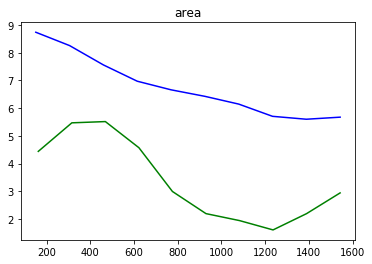

Match cir Mean 0.63054200542 Median 0.67 Min 0.1 Max 0.88
No Match cir Mean 0.337141503474 Median 0.32 Min 0.04 Max 0.86


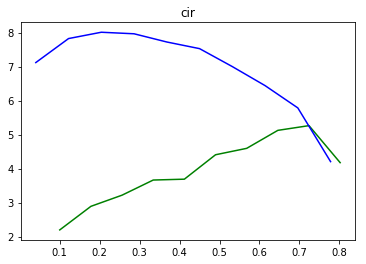

Match asp Mean 0.988495934959 Median 0.96 Min 0.3 Max 2.21
No Match asp Mean 0.810221099179 Median 0.72 Min 0.3 Max 3.0


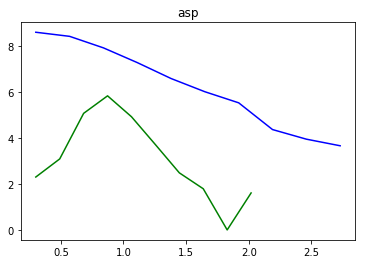

Match cheb Mean 0.574177854901 Median 0.553628925877 Min 0.140864243061 Max 0.951164448228
No Match cheb Mean 0.666695844664 Median 0.616015408831 Min 0.0710406444664 Max 0.978147597058


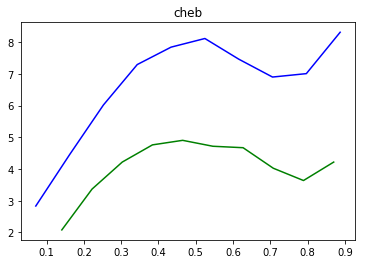

Match manhat Mean 1.83019463654 Median 1.7530531648 Min 0.441134387388 Max 3.34163066722
No Match manhat Mean 2.0960758984 Median 2.02432475692 Min 0.318053410041 Max 3.39874459408


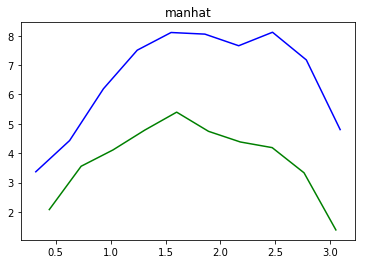

Match euclid Mean 0.8376804994 Median 0.805258817503 Min 0.211758602452 Max 1.37225072295
No Match euclid Mean 0.966443430144 Median 0.913545490834 Min 0.124897929495 Max 1.39736110685


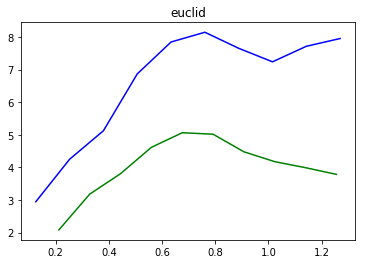

Match col Mean 52.169372303 Median 45.2300593852 Min 4.59166666667 Max 156.245412844
No Match col Mean 89.4200362154 Median 98.1213395349 Min 0.136929460581 Max 177.787878788


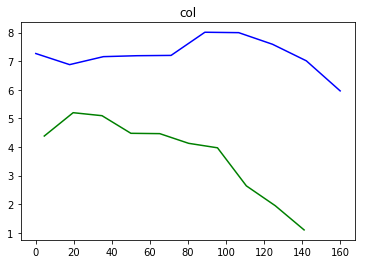

In [167]:
for metric in [('area',areas), ('cir',circles), ('asp',aspects), 
               ('cheb',chebysev), ('manhat',manhattan), ('euclid',euclidean), ('col',colors)]:
    m = metric[1]['match']
    m2 = metric[1]['no_match']
    mean = np.mean(np.array(m))
    median = np.median(np.array(m))
    mins = np.min(np.array(m))
    maxs = np.max(np.array(m))
    vals,b = np.histogram([m])
    print("Match", metric[0], "Mean", mean, "Median", median, "Min", mins, "Max", maxs)
    mean = np.mean(np.array(m2))
    median = np.median(np.array(m2))
    mins = np.min(np.array(m2))
    maxs = np.max(np.array(m2))
    
    print("No Match", metric[0], "Mean", mean, "Median", median, "Min", mins, "Max", maxs)
    
    vals2,b2 = np.histogram([m2])
#     img_hist = img_hist.flatten()
#     img_hist = img_hist / np.linalg.norm(img_hist)
    plt.plot(b[:-1], np.log(vals), color='g')
    plt.plot(b2[:-1], np.log(vals2), color='b')
    plt.title(metric[0])
    plt.show()
        

### Image Moments (centroid)

* https://en.wikipedia.org/wiki/Image_moment
* https://docs.opencv.org/3.1.0/dd/d49/tutorial_py_contour_features.html

In [ ]:
def get_moments(contours):
    moments = []
    for c in cntrs:
        M = cv2.moments(c)
        moments.append(M)
    return moments

def plot_moments(color_mask, moments):
    color_mask = color_mask.copy()
    for M in moments:
        if M["m00"] > 0.0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            cv2.circle(color_mask, (cX, cY), 7, (0, 255, 0), -1)
    plot_img(color_mask)    
    
def get_moment_centers(moments):
    centers = []
    for M in moments:
        if M["m00"] > 0.0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            centers.append([cX,cY])
    return centers

def plot_centers(img, centers):
    img = img.copy()
    for C in centers:
        x,y, = C
        cv2.circle(img, (x, y), 7, (0, 255, 0), -1)
    plot_img(img)

In [ ]:
img = load_cv2_img(metadata['fpath'][idx], colorspace=cv2.COLOR_BGR2RGB)
moments = get_moments(cntrs)
centers = get_moment_centers(moments)
plot_centers(img, centers)

## Track Ball

In [ ]:
def train_subtractor(fpaths):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    knn_subtractor = cv2.createBackgroundSubtractorKNN()
    bg_img = segment_knn(metadata['fpath'], knn_subtractor, kernel, plot_mask=False)
    return bg_img, knn_subtractor

In [ ]:
img_fpaths = metadata['fpath']
bg_img, subtractor = train_subtractor(fpaths)
binary_masks = apply_bg_mask(img_fpaths, subtractor, limit=10000, cleanup='median')
color_masks = get_masked_imgs(img_fpaths, binary_masks)
len(binary_masks), len(color_masks)

In [ ]:
binary_masks = clean_masks(binary_masks, 'median')
color_masks = clean_masks(color_masks, 'median')

In [ ]:
all_contours = []
all_bbs = []
for fpath, bm, cm in zip(fpaths, binary_masks, color_masks):
    ctrs = get_contours(bm)
    ctrs, bbs, color_hists, color_means, diameters,areas = filter_contours(ctrs, bm, cm)
    all_contours.append(ctrs)
    all_bbs.append(bbs)

In [ ]:
def get_tracked_imgs(fpaths, binary_masks, color_masks, all_bbs):
    imgs = []
    for fpath, bm, cm, bbs in zip(fpaths, binary_masks, color_masks, all_bbs):
        img = load_cv2_img(fpath, colorspace=cv2.COLOR_BGR2RGB)
        for (x1, y1, x2, y2) in bbs:
            cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), thickness=2)
        imgs.append(img)
    return imgs

In [ ]:
tracked_imgs = get_tracked_imgs(fpaths, binary_masks, color_masks, all_bbs)

## Animation

In [ ]:
fig = plt.figure()
axes = plt.axes([0, 0.03, 1, 0.97])
img = tracked_imgs[0]
imgplot = axes.imshow(img, animated=True)
def init():
    return (imgplot,)

def animate(img):
    imgplot.set_array(img)
    return (imgplot,)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=tracked_imgs, interval=30, blit=True)

In [ ]:
# ~1 minute to generate
HTML(anim.to_html5_video())

## Links

* https://github.com/abhineet123/MTF
* http://cvlab.hanyang.ac.kr/tracker_benchmark/index.html
* https://docs.opencv.org/2.4/modules/objdetect/doc/latent_svm.html
* https://www.pyimagesearch.com/2014/11/17/non-maximum-suppression-object-detection-python
* https://www.pyimagesearch.com/2015/11/16/hog-detectmultiscale-parameters-explained/
* http://lear.inrialpes.fr/people/triggs/pubs/Dalal-cvpr05.pdf
* http://mccormickml.com/2013/05/09/hog-person-detector-tutorial/
* https://www.learnopencv.com/histogram-of-oriented-gradients/
* https://stackoverflow.com/questions/34985196/opencv-using-svm-and-hog-for-person-detection
* https://www.pyimagesearch.com/2015/11/09/pedestrian-detection-opencv/